# Sprint-2. Новые данные

## Задача: Получить рабочую модель для прогона на протезе

###  Содержание <a class="anchor" id=0></a>

- [1. Загрузка библиотек, чтение данных, определение основных функций](#1)
- [2. Песочница с разными моделями](#2)
- [3. Песочница с разными пайплайнами](#3)
- [4. Эмуляция реал-тайм инференса](#4)
- [5. Итоги спринта](#5)


## 1. Загрузка библиотек, чтение данных, определение основных функций <a class="anchor" id=1></a>

[к содержанию](#0)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
pd.options.display.float_format = '{:.6f}'.format #для отображения "обычных" float
%matplotlib widget

free_movements_1 = pd.read_csv('free_movements.csv', index_col=0)
free_movements_2 = pd.read_csv('free_movements_2.csv', index_col=0)

OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
# ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
GLOVE_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
INDEX = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5', 'MSE mean', 'RUN time'] # для удобства вывода отчетов
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(GLOVE_CH)+len(BUTTON_SYNC_TS_CH) == free_movements_1.shape[-1]

gestures_train_1 = pd.read_csv('gestures_train.csv', index_col=0)
gestures_test_1 = pd.read_csv('gestures_test.csv', index_col=0)
gestures_protocol_1 = pd.read_csv('gestures_protocol.csv')

gestures_train_2 = pd.read_csv('gestures_train_2.csv', index_col=0)
gestures_test_2 = pd.read_csv('gestures_test_2.csv', index_col=0)
gestures_protocol_2 = pd.read_csv('gestures_protocol_2.csv')

gestures_train_ext_1 = pd.merge(
    gestures_train_1,
    gestures_protocol_1,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

gestures_test_ext_1 = pd.merge(
    gestures_test_1,
    gestures_protocol_1,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

gestures_train_ext_2 = pd.merge(
    gestures_train_2,
    gestures_protocol_2,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

gestures_test_ext_2 = pd.merge(
    gestures_test_2,
    gestures_protocol_2,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

Забегая вперёд, при обработке данных и подборе модели, будем пользоваться функциями которые понадобятся в эмуляции `inferenc'а` в `real-time`.

In [2]:
import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error as mse


def MSE(y, y_pred):
    """_получение среднеквадратичной ошибки для каждого таргета_

    """
    ENC0 = mse(y[:,0], y_pred[:,0])
    ENC1 = mse(y[:,1], y_pred[:,1])
    ENC2 = mse(y[:,2], y_pred[:,2])
    ENC3 = mse(y[:,3], y_pred[:,3])
    ENC4 = mse(y[:,4], y_pred[:,4])
    ENC5 = mse(y[:,5], y_pred[:,5])
    MEAN = np.mean([ENC0, ENC1, ENC2, ENC3, ENC4, ENC5])
    return pd.Series([ENC0, ENC1, ENC2, ENC3, ENC4, ENC5, MEAN])

def preprocessing_static(x, prev):
    """_добавление изменения показаний датчиков за 1 шаг
        используется в качестве препроцессинга_
    """
    if prev is None:
        y = x
    else:
        y = x - prev 
    return np.append(x, y, axis=1)

def inference(x):
    """_получение предсказаний модели_

    """
    y = np.rint(model.predict(x))

    return y

def fast_post(array, step=10):
    
    return np.round(array / step, 0).astype(int) * step


def commands(x, prev):
    """_преобразование таргетов в команды
        используется в качестве финального "коэффициента подгона"_
        пока лучшего сглаживателя нет времено использую фильтр Хольта
    """
    if prev is None:
        y = x
    else:
        y = x*0.5 + prev*0.5
    return y

## 2. Песочница с разными моделями <a class="anchor" id=2></a>

[к содержанию](#0)

Прочитаем новые данные

In [3]:
X_1 = gestures_train_1[OMG_CH].values
X_test_1 = gestures_test_1[OMG_CH].values
y_1 = gestures_train_1[GLOVE_CH].values
y_test_1 = gestures_test_1[GLOVE_CH].values
print(X_1.shape, y_1.shape, X_test_1.shape, y_test_1.shape)

X_2 = gestures_train_2[OMG_CH].values
X_test_2 = gestures_test_2[OMG_CH].values
y_2 = gestures_train_2[GLOVE_CH].values
y_test_2 = gestures_test_2[GLOVE_CH].values
X_2.shape, y_2.shape, X_test_2.shape, y_test_2.shape


(28976, 50) (28976, 6) (7244, 50) (7244, 6)


((21320, 50), (21320, 6), (5330, 50), (5330, 6))

Посмотрим на таргеты, для разных пилотов

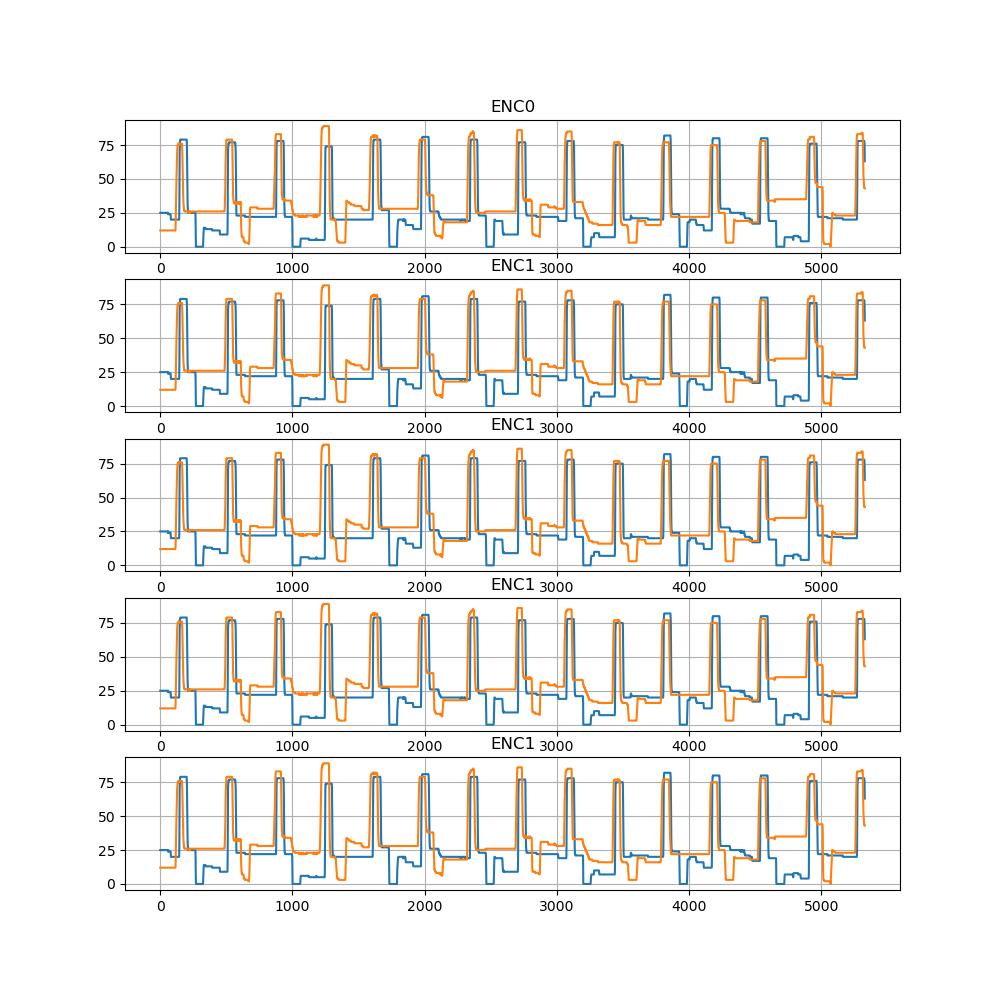

In [4]:
fig, ax = plt.subplots(5, 1, figsize=(10, 10))

ax[0].set_title('ENC0')
ax[0].plot(y_test_1[:,0][:5330])
ax[0].plot(y_test_2[:,0][:5330])
ax[0].grid()

ax[1].set_title('ENC1')
ax[1].plot(y_test_1[:,0][:5330])
ax[1].plot(y_test_2[:,0][:5330])
ax[1].grid()

ax[2].set_title('ENC1')
ax[2].plot(y_test_1[:,0][:5330])
ax[2].plot(y_test_2[:,0][:5330])
ax[2].grid()

ax[3].set_title('ENC1')
ax[3].plot(y_test_1[:,0][:5330])
ax[3].plot(y_test_2[:,0][:5330])
ax[3].grid()

ax[4].set_title('ENC1')
ax[4].plot(y_test_1[:,0][:5330])
ax[4].plot(y_test_2[:,0][:5330])
ax[4].grid()


Видим, что оба пилота выполняют одни и теже жесты.

Проверим работу датчиков на обоих пилотах

In [5]:
pilot_1_active_OMG = []
pilot_2_active_OMG = []
pilot_1_inactive_OMG = []
pilot_2_inactive_OMG = []

for i in np.arange(X_test_1.shape[1]):
    if (X_test_1[:,i] < 200).any():
        pilot_1_inactive_OMG.append(i)
    else:
        pilot_1_active_OMG.append(i)

for i in np.arange(X_test_2.shape[1]):
    if (X_test_2[:,i] < 200).any():
        pilot_2_inactive_OMG.append(i)
    else:
        pilot_2_active_OMG.append(i)

pilot_1_active_OMG = np.array(pilot_1_active_OMG)
pilot_2_active_OMG = np.array(pilot_2_active_OMG)
pilot_1_inactive_OMG = np.array(pilot_1_inactive_OMG)
pilot_2_inactive_OMG = np.array(pilot_2_inactive_OMG)

print('Активных датчиков:')
print(f'первый пилот: {pilot_1_active_OMG.shape[0]}\nвторой пилот: {pilot_2_active_OMG.shape[0]}')
print('Пассивных датчиков:')
print(f'первый пилот: {pilot_1_inactive_OMG.shape[0]}\nвторой пилот: {pilot_2_inactive_OMG.shape[0]}')
print(f'Номера этих датчиков совпадают: {(pilot_1_active_OMG == pilot_2_active_OMG).any()}')

Активных датчиков:
первый пилот: 16
второй пилот: 16
Пассивных датчиков:
первый пилот: 34
второй пилот: 34
Номера этих датчиков совпадают: True


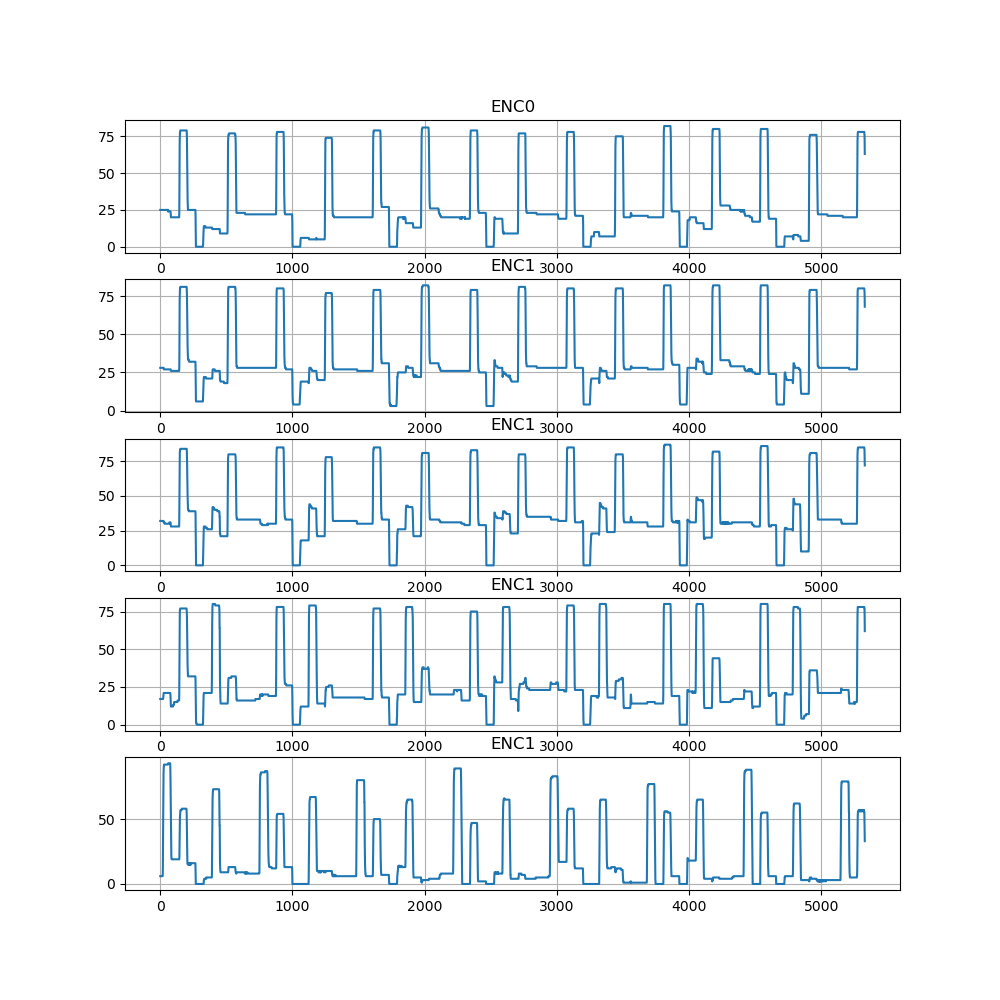

In [6]:
fig, ax = plt.subplots(5, 1, figsize=(10, 10))

ax[0].set_title('ENC0')
ax[0].plot(y_test_1[:,0][:5330])
ax[0].grid()

ax[1].set_title('ENC1')
ax[1].plot(y_test_1[:,1][:5330])
ax[1].grid()

ax[2].set_title('ENC1')
ax[2].plot(y_test_1[:,2][:5330])
ax[2].grid()

ax[3].set_title('ENC1')
ax[3].plot(y_test_1[:,3][:5330])
ax[3].grid()

ax[4].set_title('ENC1')
ax[4].plot(y_test_1[:,4][:5330])
ax[4].grid()

Text(740, 500, 'thumb up')

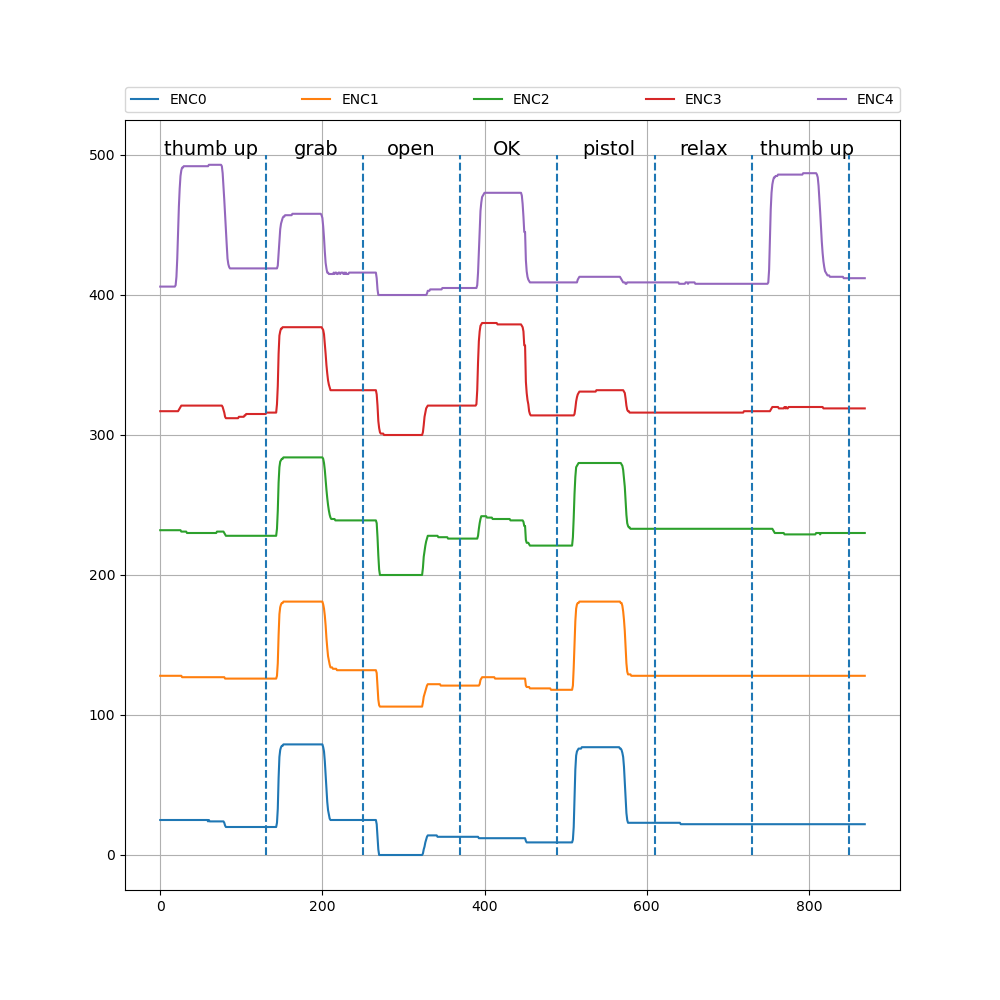

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(y_test_1[:,0][:870], label='ENC0')
ax.plot(y_test_1[:,1][:870] + 100, label='ENC1')
ax.plot(y_test_1[:,2][:870] + 200, label='ENC2')
ax.plot(y_test_1[:,3][:870] + 300, label='ENC3')
ax.plot(y_test_1[:,4][:870] + 400, label='ENC4')
ax.legend(bbox_to_anchor=(0, 1.01, 1, 1.01), loc='lower left',
                      ncols=5, mode="expand", borderaxespad=0.)
ax.grid()
ax.vlines(130, 0, 500, linestyles='--')
ax.vlines(250, 0, 500, linestyles='--')
ax.vlines(370, 0, 500, linestyles='--')
ax.vlines(490, 0, 500, linestyles='--')
ax.vlines(610, 0, 500, linestyles='--')
ax.vlines(730, 0, 500, linestyles='--')
ax.vlines(850, 0, 500, linestyles='--')

ax.text(5,500, 'thumb up', fontsize=14)
ax.text(165,500, 'grab', fontsize=14)
ax.text(280,500, 'open', fontsize=14)
ax.text(410,500, 'OK', fontsize=14)
ax.text(520,500, 'pistol', fontsize=14)
ax.text(640,500, 'relax', fontsize=14)
ax.text(740,500, 'thumb up', fontsize=14)

Text(740, 500, 'thumb up')

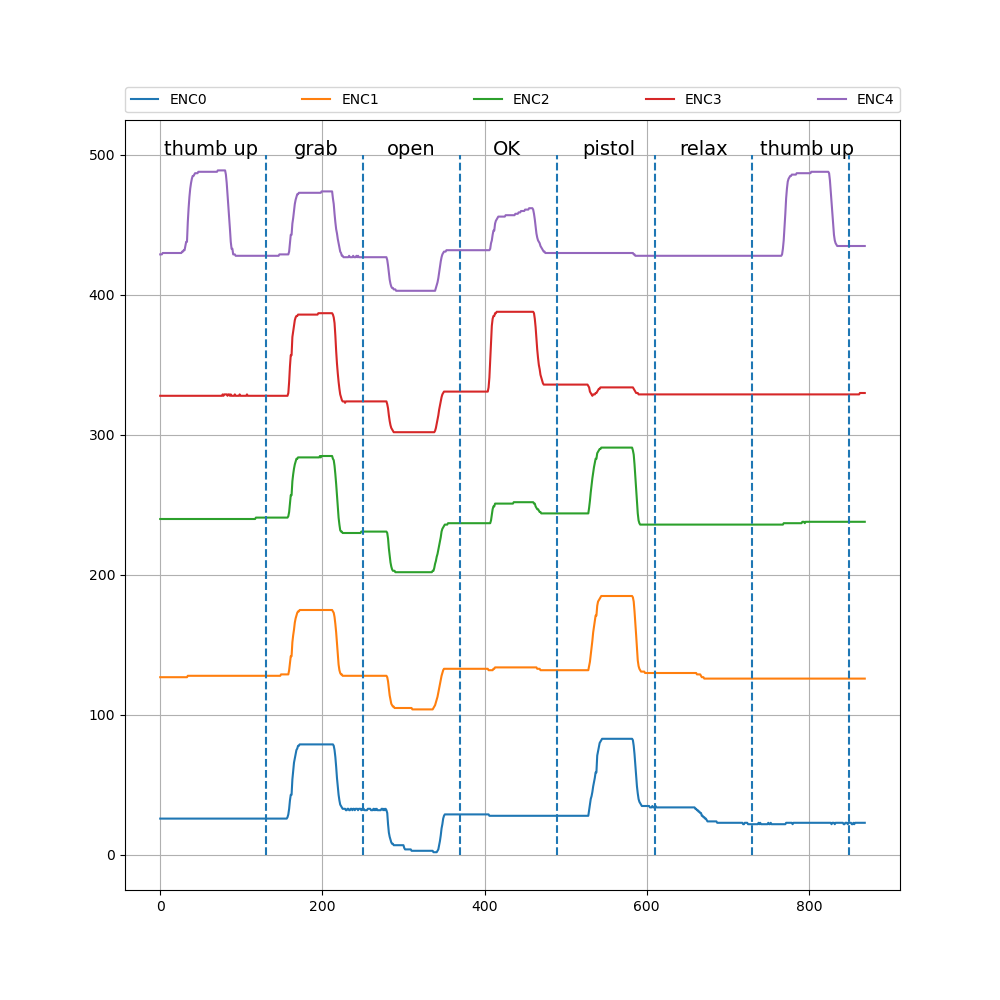

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(y_test_2[:,0][330:1200], label='ENC0')
ax.plot(y_test_2[:,1][330:1200] + 100, label='ENC1')
ax.plot(y_test_2[:,2][330:1200] + 200, label='ENC2')
ax.plot(y_test_2[:,3][330:1200] + 300, label='ENC3')
ax.plot(y_test_2[:,4][330:1200] + 400, label='ENC4')
ax.legend(bbox_to_anchor=(0, 1.01, 1, 1.01), loc='lower left',
                      ncols=5, mode="expand", borderaxespad=0.)
ax.grid()
ax.vlines(130, 0, 500, linestyles='--')
ax.vlines(250, 0, 500, linestyles='--')
ax.vlines(370, 0, 500, linestyles='--')
ax.vlines(490, 0, 500, linestyles='--')
ax.vlines(610, 0, 500, linestyles='--')
ax.vlines(730, 0, 500, linestyles='--')
ax.vlines(850, 0, 500, linestyles='--')

ax.text(5,500, 'thumb up', fontsize=14)
ax.text(165,500, 'grab', fontsize=14)
ax.text(280,500, 'open', fontsize=14)
ax.text(410,500, 'OK', fontsize=14)
ax.text(520,500, 'pistol', fontsize=14)
ax.text(640,500, 'relax', fontsize=14)
ax.text(740,500, 'thumb up', fontsize=14)

In [9]:
def get_diff(array, min=-400, max=400):
    new_array = np.sum(array, axis=1) - np.sum(np.vstack([array[1:], array[:1]]), axis=1)
    new_array[(new_array < 0) & (new_array > min)] = 0
    new_array[(new_array > 0) & (new_array < max)] = 0
    return new_array

In [10]:
def classer(array, min=0.1, max=0.6):
    new_array = np.sum(array, axis=1)
    new_array[new_array <= np.quantile(new_array, 0.1)] = 0
    new_array[(new_array > np.quantile(new_array, 0.1)) & (new_array < np.quantile(new_array, 0.6))] = 1
    new_array[(new_array != 0) & (new_array != 1)] = 2
    return new_array

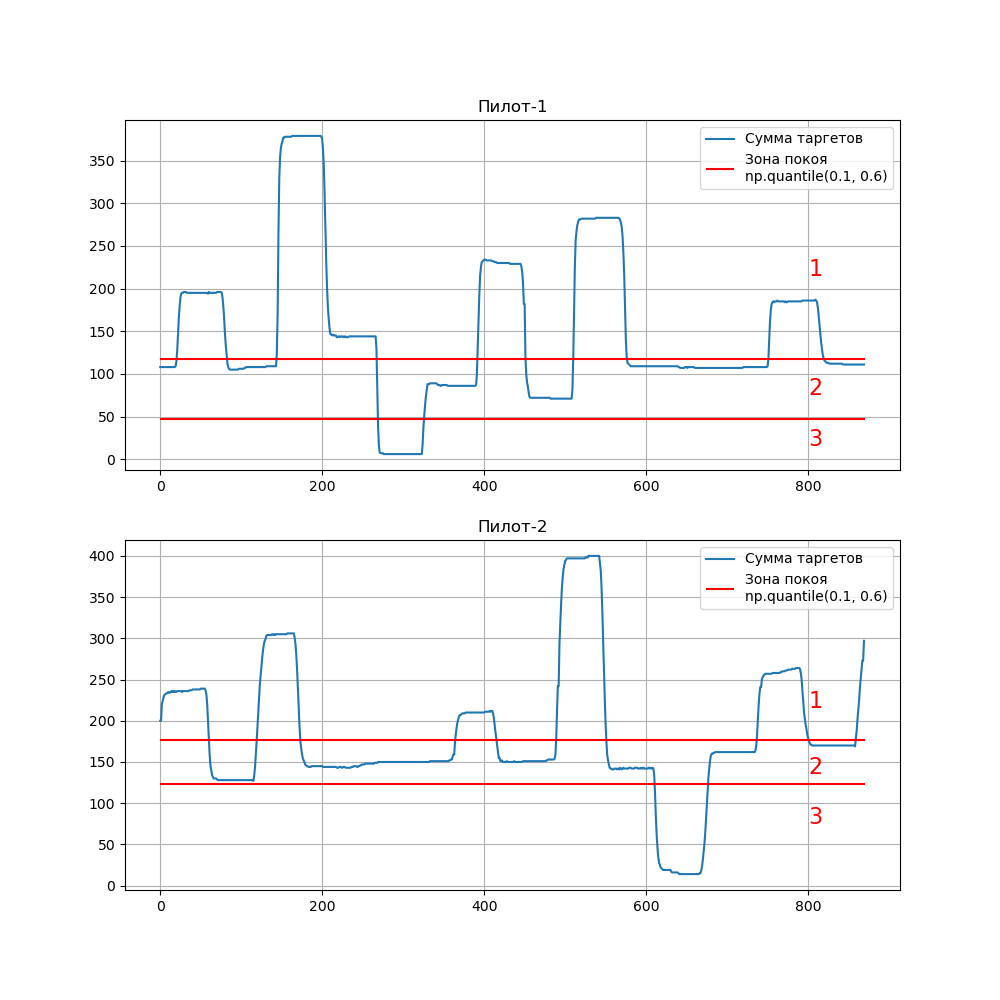

In [11]:
fig, ax = plt.subplots(2,1, figsize=(10, 10))


ax[0].plot(np.sum(y_test_1[:870], axis=1), label='Сумма таргетов')
ax[0].hlines(np.quantile(np.sum(y_test_1, axis=1), 0.1), 0, 870, color='r', label='Зона покоя\nnp.quantile(0.1, 0.6)')
ax[0].hlines(np.quantile(np.sum(y_test_1, axis=1), 0.6), 0, 870, color='r')
ax[0].grid()
ax[0].set_title('Пилот-1')
ax[0].text(800, 215, '1', color='r', fontsize=16)
ax[0].text(800, 75, '2', color='r', fontsize=16)
ax[0].text(800, 15, '3', color='r', fontsize=16)
ax[0].legend()

ax[1].plot(np.sum(y_test_2[:870], axis=1), label='Сумма таргетов')
ax[1].hlines(np.quantile(np.sum(y_test_2, axis=1), 0.1), 0, 870, color='r', label='Зона покоя\nnp.quantile(0.1, 0.6)')
ax[1].hlines(np.quantile(np.sum(y_test_2, axis=1), 0.6), 0, 870, color='r')
ax[1].grid()
ax[1].set_title('Пилот-2')
ax[1].text(800, 215, '1', color='r', fontsize=16)
ax[1].text(800, 135, '2', color='r', fontsize=16)
ax[1].text(800, 75, '3', color='r', fontsize=16)
ax[1].legend()

In [12]:
X = np.vstack([X_1, X_2])
y = np.vstack([y_1, y_2])
X_test = np.vstack([X_test_1, X_test_2])
y_test = np.vstack([y_test_1, y_test_2])
X.shape, y.shape, X_test.shape, y_test.shape

((50296, 50), (50296, 6), (12574, 50), (12574, 6))

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error as mse

y_class = classer(y)
y_test_class = classer(y_test)

LogR = LogisticRegression().fit(X, y_class)

y_pred = LogR.predict(X)
y_test_pred = LogR.predict(X_test)

print(f'train: {mse(y_class, y_pred)}')
print(f'test: {mse(y_test_class, y_test_pred)}')

train: 0.22858676634324798
test: 0.20407189438523937


## Пока отложим классификатор, пробежимся по базовым моделям

и послотрим насколько плохо будет, если мы обучим модель на данных первого пилота а предсказания снимем со второго

***
## Соберём данный обоих пилотов в один сет и обучим модельки

In [14]:
X = np.vstack([X_1, X_2])
y = np.vstack([y_1, y_2])
X_test = np.vstack([X_test_1, X_test_2])
y_test = np.vstack([y_test_1, y_test_2])
X.shape, y.shape, X_test.shape, y_test.shape

((50296, 50), (50296, 6), (12574, 50), (12574, 6))

In [15]:
# ~0.5s
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(X, y)

pilot_1 = MSE(y_test_1, lr.predict(X_test_1))
pilot_2 = MSE(y_test_2, lr.predict(X_test_2))

lr_full_data = pd.DataFrame({'INDEX':['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5', 'MSE mean'],'lr_pilot_1':pilot_1, 'lr_pilot_2':pilot_2}).set_index('INDEX')
lr_full_data

,lr_pilot_1,lr_pilot_2
INDEX,,
ENC0,144.452417,149.452798
ENC1,101.116083,117.938012
ENC2,117.696557,108.818361
ENC3,107.812676,180.603738
ENC4,413.214784,105.420510
ENC5,0.000000,0.000000
MSE mean,147.382086,110.372236


In [16]:
# ~25s
from sklearn.linear_model import ElasticNet

en = ElasticNet().fit(X, y)

pilot_1 = MSE(y_test_1, en.predict(X_test_1))
pilot_2 = MSE(y_test_2, en.predict(X_test_2))

en_full_data = pd.DataFrame({'INDEX':['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5', 'MSE mean'],'en_pilot_1':pilot_1, 'en_pilot_2':pilot_2}).set_index('INDEX')
en_full_data

,en_pilot_1,en_pilot_2
INDEX,,
ENC0,143.110811,154.396532
ENC1,100.382778,122.247244
ENC2,116.366246,111.354833
ENC3,105.482038,182.943771
ENC4,415.856617,102.187213
ENC5,0.000000,0.000000
MSE mean,146.866415,112.188265


In [17]:
# время выполнения ~ 10s
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoLars
from sklearn.ensemble import VotingRegressor

estimators = [
    ('dt', DecisionTreeRegressor()),('ll', LassoLars(alpha=0.1))
]
model_vr = MultiOutputRegressor(VotingRegressor(estimators=estimators, weights=[0.45, 0.55])).fit(X, y)

pilot_1 = MSE(y_test_1, model_vr.predict(X_test_1))
pilot_2 = MSE(y_test_2, model_vr.predict(X_test_2))

vr_full_data = pd.DataFrame({'INDEX':['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5', 'MSE mean'],'vr_pilot_1':pilot_1, 'vr_pilot_2':pilot_2}).set_index('INDEX')
vr_full_data

,vr_pilot_1,vr_pilot_2
INDEX,,
ENC0,113.695678,121.660632
ENC1,86.217862,72.470512
ENC2,93.285151,63.966475
ENC3,91.780019,118.252069
ENC4,346.858641,77.602123
ENC5,0.000000,0.000000
MSE mean,121.972892,75.658635


In [18]:
# время выполнения ~ 22s
import xgboost as xgb

# параметры оптимизированы optun'ой
params = {'learning_rate': 0.06329973864656831,
 'max_depth': 6,
 'subsample': 0.9814063371832862,
 'colsample_bytree': 0.41087811860602663,
 'min_child_weight': 8}

model_xgb = xgb.XGBRegressor(**params)
model_xgb.fit(X, y)

pilot_1 = MSE(y_test_1, model_xgb.predict(X_test_1))
pilot_2 = MSE(y_test_2, model_xgb.predict(X_test_2))

xgb_full_data = pd.DataFrame({'INDEX':['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5', 'MSE mean'],'xgb_pilot_1':pilot_1, 'xgb_pilot_2':pilot_2}).set_index('INDEX')
xgb_full_data

,xgb_pilot_1,xgb_pilot_2
INDEX,,
ENC0,93.592520,121.949292
ENC1,54.265329,77.797997
ENC2,71.479162,52.677084
ENC3,64.493455,62.019091
ENC4,293.251190,51.740474
ENC5,0.000001,0.000001
MSE mean,96.180276,61.030657


In [19]:
# время выполнения ~ 4.5s
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb

# параметры оптимизированы optun'ой
params = {'learning_rate': 0.07118878873086158,
 'num_leaves': 78,
 'max_depth': 159,
 'min_data_in_leaf': 1423}

model_lgb = MultiOutputRegressor(lgb.LGBMRegressor(**params))
model_lgb.fit(X, y)

pilot_1 = MSE(y_test_1, model_lgb.predict(X_test_1))
pilot_2 = MSE(y_test_2, model_lgb.predict(X_test_2))

lgb_full_data = pd.DataFrame({'INDEX':['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5', 'MSE mean'],'lgb_pilot_1':pilot_1, 'lgb_pilot_2':pilot_2}).set_index('INDEX')
lgb_full_data

[LightGBM] [Warning] min_data_in_leaf is set=1423, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1423


,lgb_pilot_1,lgb_pilot_2
INDEX,,
ENC0,86.738974,152.108946
ENC1,60.442739,102.552523
ENC2,78.668825,59.070663
ENC3,72.426480,98.867079
ENC4,284.330516,122.703637
ENC5,0.000000,0.000000
MSE mean,97.101256,89.217141


In [21]:
Models_full_df = pd.concat([lr_full_data, vr_full_data, en_full_data, xgb_full_data, lgb_full_data], axis=1)
Models_full_df

,lr_pilot_1,lr_pilot_2,vr_pilot_1,vr_pilot_2,en_pilot_1,en_pilot_2,xgb_pilot_1,xgb_pilot_2,lgb_pilot_1,lgb_pilot_2
INDEX,,,,,,,,,,
ENC0,144.452417,149.452798,113.695678,121.660632,143.110811,154.396532,93.592520,121.949292,86.738974,152.108946
ENC1,101.116083,117.938012,86.217862,72.470512,100.382778,122.247244,54.265329,77.797997,60.442739,102.552523
ENC2,117.696557,108.818361,93.285151,63.966475,116.366246,111.354833,71.479162,52.677084,78.668825,59.070663
ENC3,107.812676,180.603738,91.780019,118.252069,105.482038,182.943771,64.493455,62.019091,72.426480,98.867079
ENC4,413.214784,105.420510,346.858641,77.602123,415.856617,102.187213,293.251190,51.740474,284.330516,122.703637
ENC5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000001,0.000001,0.000000,0.000000
MSE mean,147.382086,110.372236,121.972892,75.658635,146.866415,112.188265,96.180276,61.030657,97.101256,89.217141


In [22]:
Models_full_df[['vr_pilot_1', 'xgb_pilot_1', 'lgb_pilot_1']]

,vr_pilot_1,xgb_pilot_1,lgb_pilot_1
INDEX,,,
ENC0,113.695678,93.592520,86.738974
ENC1,86.217862,54.265329,60.442739
ENC2,93.285151,71.479162,78.668825
ENC3,91.780019,64.493455,72.426480
ENC4,346.858641,293.251190,284.330516
ENC5,0.000000,0.000001,0.000000
MSE mean,121.972892,96.180276,97.101256


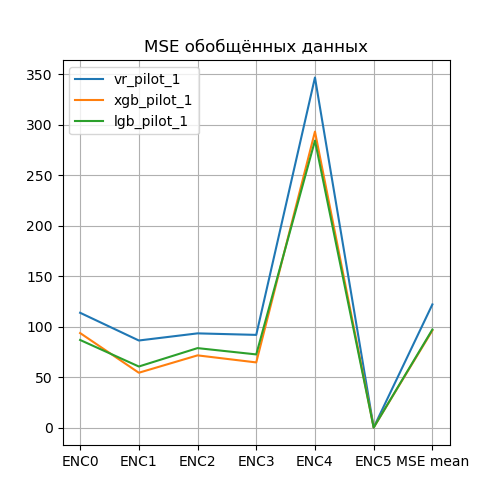

In [23]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.set_title('MSE обобщённых данных')
ax.plot(Models_full_df[['vr_pilot_1', 'xgb_pilot_1', 'lgb_pilot_1']], label=['vr_pilot_1', 'xgb_pilot_1', 'lgb_pilot_1'])
ax.legend()
ax.grid()

***
### От "нечего делать" соберём свою линейную регрессию ~~с блэк джеком и шлюхами~~

In [27]:
def get_weight(X, y):
    """_вычислятель коэффициентов (весов) линейной регрессии_
    """              
    return np.linalg.inv(X.T @ X) @ X.T @ y

lr_weight = get_weight(X_1, y_1)

In [28]:
def get_predict(X, weight):

    return X @ lr_weight

In [30]:
print(f'X_1.shape: {X_1.shape}')
print(f'y_1.shape: {y_1.shape}')
print(f'y_pred: {get_predict(X_1, lr_weight).shape}')

X_1.shape: (28976, 50)
y_1.shape: (28976, 6)
y_pred: (28976, 6)


Ну и зачем нам линейка из sklearn?
У нас есть линейка дома.

***
### Давайка бахнем классификатор

In [46]:
X_1 = gestures_train_1[OMG_CH].values
X_test_1 = gestures_test_1[OMG_CH].values
y_1 = gestures_train_1[GLOVE_CH].values
y_test_1 = gestures_test_1[GLOVE_CH].values

X_2 = gestures_train_2[OMG_CH].values
X_test_2 = gestures_test_2[OMG_CH].values
y_2 = gestures_train_2[GLOVE_CH].values
y_test_2 = gestures_test_2[GLOVE_CH].values

X = np.vstack([X_1, X_2])
y = np.vstack([y_1, y_2])
X_test = np.vstack([X_test_1, X_test_2])
y_test = np.vstack([y_test_1, y_test_2])
X.shape, y.shape, X_test.shape, y_test.shape

((50296, 50), (50296, 6), (12574, 50), (12574, 6))

In [47]:
# ~25s
import lightgbm as lgb

def get_class(X, y, X_test, step=10):
    
    y_for_lgb = np.round(y / step, 0).astype(int)
    
    booster_0 = lgb.train({
        "objective": "multiclass",
        "num_class":11},
        train_set=lgb.Dataset(X, y_for_lgb[:,0]),
        num_boost_round=100)
    booster_1 = lgb.train({
        "objective": "multiclass",
        "num_class":11},
        train_set=lgb.Dataset(X, y_for_lgb[:,1]),
        num_boost_round=100)
    booster_2 = lgb.train({
        "objective": "multiclass",
        "num_class":11},
        train_set=lgb.Dataset(X, y_for_lgb[:,2]),
        num_boost_round=100)
    booster_3 = lgb.train({
        "objective": "multiclass",
        "num_class":11},
        train_set=lgb.Dataset(X, y_for_lgb[:,3]),
        num_boost_round=100)
    booster_4 = lgb.train({
        "objective": "multiclass",
        "num_class":11},
        train_set=lgb.Dataset(X, y_for_lgb[:,4]),
        num_boost_round=100)
    booster_5 = lgb.train({
        "objective": "multiclass",
        "num_class":11},
        train_set=lgb.Dataset(X, y_for_lgb[:,5]),
        num_boost_round=100)
    
    y_0 = np.argmax(booster_0.predict(X_test), axis=1) * step
    y_1 = np.argmax(booster_1.predict(X_test), axis=1) * step
    y_2 = np.argmax(booster_2.predict(X_test), axis=1) * step
    y_3 = np.argmax(booster_3.predict(X_test), axis=1) * step
    y_4 = np.argmax(booster_4.predict(X_test), axis=1) * step
    y_5 = np.argmax(booster_5.predict(X_test), axis=1) * step
    
    return np.vstack([y_0, y_1, y_2, y_3, y_4, y_5]).T

## 4. Эмуляция реал-тайм инференса <a class="anchor" id=4></a>

[к содержанию](#0)

In [37]:
import time
#import serial
from IPython.display import clear_output

In [38]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

In [51]:
gestures_train_1 = pd.read_csv('gestures_train.csv', index_col=0)
gestures_test_1 = pd.read_csv('gestures_test.csv', index_col=0)
gestures_protocol_1 = pd.read_csv('gestures_protocol.csv')

gestures_train_2 = pd.read_csv('gestures_train_2.csv', index_col=0)
gestures_test_2 = pd.read_csv('gestures_test_2.csv', index_col=0)
gestures_protocol_2 = pd.read_csv('gestures_protocol_2.csv')

X_1 = gestures_train_1[OMG_CH].values
X_test_1 = gestures_test_1[OMG_CH].values
y_1 = gestures_train_1[GLOVE_CH].values
y_test_1 = gestures_test_1[GLOVE_CH].values


X_2 = gestures_train_2[OMG_CH].values
X_test_2 = gestures_test_2[OMG_CH].values
y_2 = gestures_train_2[GLOVE_CH].values
y_test_2 = gestures_test_2[GLOVE_CH].values

X = np.vstack([X_1, X_2])
y = np.vstack([y_1, y_2])
X_test = np.vstack([X_test_1, X_test_2])
y_test = np.vstack([y_test_1, y_test_2])

In [52]:
# время выполнения ~ 10s
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoLars
from sklearn.ensemble import VotingRegressor

estimators = [
    ('dt', DecisionTreeRegressor()),('ll', LassoLars(alpha=0.1))
]
model_vr = MultiOutputRegressor(VotingRegressor(estimators=estimators, weights=[0.45, 0.55])).fit(X, y)

In [53]:
# ~0.2s
from sklearn.linear_model import LinearRegression

model_ll = LinearRegression()

model_ll.fit(X, y)

LinearRegression()

In [54]:
# время выполнения ~ 22s
import xgboost as xgb

# параметры оптимизированы optun'ой
params = {'learning_rate': 0.06329973864656831,
 'max_depth': 6,
 'subsample': 0.9814063371832862,
 'colsample_bytree': 0.41087811860602663,
 'min_child_weight': 8}

model_xgb = xgb.XGBRegressor(**params)
model_xgb.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.41087811860602663, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.06329973864656831,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [55]:
# время выполнения ~ 4.5s
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb

# параметры оптимизированы optun'ой
params = {'learning_rate': 0.07118878873086158,
 'num_leaves': 78,
 'max_depth': 159,
 'min_data_in_leaf': 1423}

model_lgb = MultiOutputRegressor(lgb.LGBMRegressor(**params))
model_lgb.fit(X, y)

[LightGBM] [Warning] min_data_in_leaf is set=1423, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1423


MultiOutputRegressor(estimator=LGBMRegressor(learning_rate=0.07118878873086158,
                                             max_depth=159,
                                             min_data_in_leaf=1423,
                                             num_leaves=78))

In [56]:
# ~20s
import lightgbm as lgb

step = 10

y_for_lgb = np.round(y / step, 0).astype(int)
    
booster_0 = lgb.train({
        "objective": "multiclass",
        "num_class":11},
        train_set=lgb.Dataset(X, y_for_lgb[:,0]),
        num_boost_round=100)
booster_1 = lgb.train({
        "objective": "multiclass",
        "num_class":11},
        train_set=lgb.Dataset(X, y_for_lgb[:,1]),
        num_boost_round=100)
booster_2 = lgb.train({
        "objective": "multiclass",
        "num_class":11},
        train_set=lgb.Dataset(X, y_for_lgb[:,2]),
        num_boost_round=100)
booster_3 = lgb.train({
        "objective": "multiclass",
        "num_class":11},
        train_set=lgb.Dataset(X, y_for_lgb[:,3]),
        num_boost_round=100)
booster_4 = lgb.train({
        "objective": "multiclass",
        "num_class":11},
        train_set=lgb.Dataset(X, y_for_lgb[:,4]),
        num_boost_round=100)
booster_5 = lgb.train({
        "objective": "multiclass",
        "num_class":11},
        train_set=lgb.Dataset(X, y_for_lgb[:,5]),
        num_boost_round=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6124
[LightGBM] [Info] Number of data points in the train set: 50296, number of used features: 50
[LightGBM] [Info] Start training from score -2.281067
[LightGBM] [Info] Start training from score -1.777624
[LightGBM] [Info] Start training from score -0.768271
[LightGBM] [Info] Start training from score -2.355789
[LightGBM] [Info] Start training from score -3.943243
[LightGBM] [Info] Start training from score -5.219879
[LightGBM] [Info] Start training from score -5.079478
[LightGBM] [Info] Start training from score -3.770368
[LightGBM] [Info] Start training from score -2.365270
[LightGBM] [Info] Start training from score -4.042356
[LightGBM] [Info] Start training from score -5.378943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

In [57]:
def get_predict(x, step=10):
    y_0 = np.argmax(booster_0.predict([x]), axis=1) * step
    y_1 = np.argmax(booster_1.predict([x]), axis=1) * step
    y_2 = np.argmax(booster_2.predict([x]), axis=1) * step
    y_3 = np.argmax(booster_3.predict([x]), axis=1) * step
    y_4 = np.argmax(booster_4.predict([x]), axis=1) * step
    y_5 = np.argmax(booster_5.predict([x]), axis=1) * step
    return np.hstack([y_0, y_1, y_2, y_3, y_4, y_5])

In [59]:
# ~3m
import xgboost as xgb
def XGB(*data):
    X_train, X_test, y_train, y_test = data
    train = xgb.DMatrix(X_train, label=y_train)
    test = xgb.DMatrix(X_test, y_test)
    params={'booster':'gbtree',
        'objective': 'binary:logistic',
        'eval_metric':'logloss',
        'gamma':0.1, # Control the number of leaf nodes
        'min_child_weight':1,
        'max_depth':6,
        'lambda':10, # Leaf node score l2 regular
        'alpha':0.1, # Leaf node score l1 regular
        'subsample':0.7,
        'colsample_bytree':0.7,
        'eta': 0.01,
        'seed':0, }
    watchlist = [(train,'train'),(test,'test')]
    model = xgb.train(params,train,num_boost_round=5000,evals=watchlist, early_stopping_rounds=10)
    return model

In [60]:
def get_xgb(x):
    return model_xgb.predict(xgb.DMatrix([x]))[0]*100

In [39]:
from sklearn.metrics import mean_squared_error as mse

import collections

dq = collections.deque(maxlen=4)

def MSE(y, y_pred):
    """_получение среднеквадратичной ошибки для каждого таргета_

    """
    ENC0 = mse(y[:,0], y_pred[:,0])
    ENC1 = mse(y[:,1], y_pred[:,1])
    ENC2 = mse(y[:,2], y_pred[:,2])
    ENC3 = mse(y[:,3], y_pred[:,3])
    ENC4 = mse(y[:,4], y_pred[:,4])
    ENC5 = mse(y[:,5], y_pred[:,5])
    return pd.Series([ENC0, ENC1, ENC2, ENC3, ENC4, ENC5])

def preprocessing(x):
    # x - sample vector
    y = x
    return y

def inference(x):
    y = model_xgb.predict([x])[0]
    return y

def postprocessing(array, step=10):

    array[array < 0] = 0
    array = np.round(array / step, 0).astype(int) * step
    return array

def do_deque(dq):
    if len(dq) < 2:
        return np.zeros(6)
    else:
        if (dq[-1] == dq[0]).any():
            dq[1][dq[-1] == dq[0]] = dq[0][dq[-1] == dq[0]]
    return dq[0]

def do_deque_1(dq): #при использовании её укажи maxlen=4 в dq
    if len(dq) < 3:
        return np.zeros(6)
    else:
        if (dq[-1] == dq[0]).any():
            dq[1][dq[-1] == dq[0]] = dq[0][dq[-1] == dq[0]]
            dq[2][dq[-1] == dq[0]] = dq[0][dq[-1] == dq[0]]
    return dq[0]

def commands(x, prev):
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y

In [40]:
df_sim = gestures_test_1.iloc[:10000]
#df_sim = free_movements.iloc[:2000]
print(df_sim.shape)

(7244, 65)


In [41]:
TIMEOUT = 0.33
DEBUG = True
    
i = 0
ts_old = time.time()
ts_diff = 0;

dq = collections.deque(maxlen=3)
pred_previous = None
y_previous = None

y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
    #'y_list':[],
}

while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted)
    # [/Inference Postprocessing]

    # [Commands composition]
    do_deque(dq)
    # [/Commands composition]
        
    # [Commands composition]
    y_commands          = commands(y_postprocessed, y_previous)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)  
    y_dct['y_commands'].append(y_commands)
    
    dq.append(y_postprocessed)
    
    y_previous = y_postprocessed
    
    # [/Data logging]
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    
    ts_old = ts_start
    i += 1 

SAMPLE SIZE: 65, OMG: 50, ACC: 6, ENCODERS: 6
BUTTON: 0, SYNC: 295, TS: 2370183
[20. 20. 30. 20. 10.  0.]


In [43]:
#y_dct['y_commands'] = y_dct['y_commands'][1:]

for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (7244, 50)
enc_sample.shape = (7244, 6)
sample_preprocessed.shape = (7244, 50)
y_predicted.shape = (7244, 6)
y_postprocessed.shape = (7244, 6)
y_commands.shape = (7244, 6)


In [46]:
df_sim.values[0]

array([     10,       9,      38,    2994,    3119,    2996,    2773,
            38,       9,       6,       0,      57,    2033,    2202,
            52,      37,    2700,    3021,      49,       6,      38,
          2725,    1863,      64,      11,       7,      41,    2118,
          1382,      31,    2697,    1819,      43,      18,       6,
             4,      10,      46,    1495,    1385,      35,      22,
            12,      13,       8,       5,       8,      11,      35,
            28,     -23,     -26,     189,      14,     -38,      19,
            25,      28,      32,      17,       6,       0,       0,
             0, 2131164], dtype=int64)

In [49]:
for i in np.arange(df_sim.shape[0]):
    
    omg_sample = df_sim[OMG_CH].values[i]
    
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted)
    # [/Inference Postprocessing]

    # [Commands composition]
    do_deque(dq)
    # [/Commands composition]
        
    # [Commands composition]
    y_commands          = commands(y_postprocessed, y_previous)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)  
    y_dct['y_commands'].append(y_commands)
    
    dq.append(y_postprocessed)
    
    y_previous = y_postprocessed

AttributeError: 'numpy.ndarray' object has no attribute 'append'

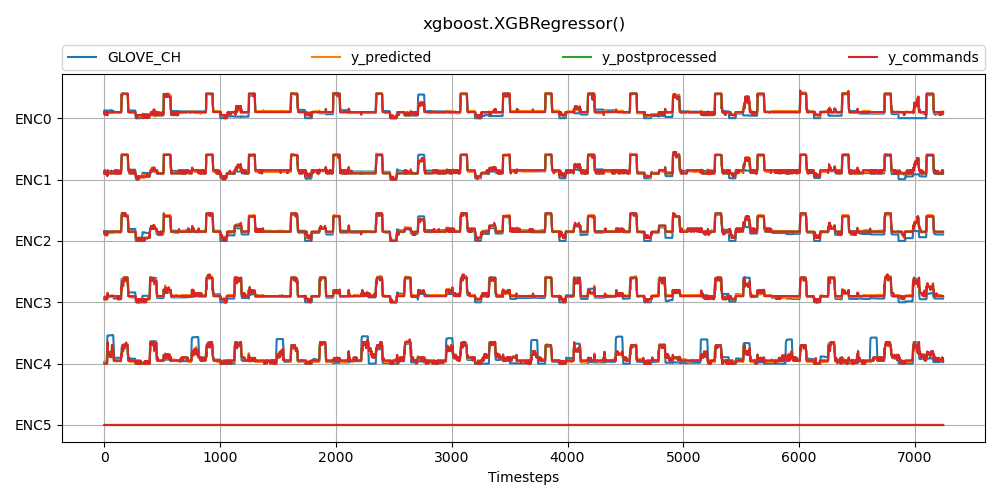

In [71]:
plt.clf()
fig = plt.figure(figsize=(10, 5))

lines = []
labels = []

plots = plt.plot(df_sim[GLOVE_CH].values - np.arange(len(GLOVE_CH)) * 200, c='C0')
lines += [plots[0]]
labels += ['GLOVE_CH']

plots = plt.plot(y_dct['y_predicted'] - np.arange(len(GLOVE_CH)) * 200, c='C1')
lines += [plots[0]]
labels += ['y_predicted']

plots = plt.plot(y_dct['y_postprocessed'] - np.arange(len(GLOVE_CH)) * 200, c='C2')
lines += [plots[0]]
labels += ['y_postprocessed']

plots = plt.plot(y_dct['y_commands'] - np.arange(len(GLOVE_CH)) * 200, c='C3')
lines += [plots[0]]
labels += ['y_commands']

plt.title('xgboost.XGBRegressor()', y=1.1)
plt.yticks(-np.arange(len(GLOVE_CH)) * 200, GLOVE_CH)
#plt.legend(lines, labels)
plt.legend(lines, labels, bbox_to_anchor=(0, 1.01, 1, 1.01), loc='lower left',
                      ncols=5, mode="expand", borderaxespad=0.)
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

In [72]:
MSE(y_dct['enc_sample'], y_dct['y_postprocessed'])

0    97.836278
1    64.498896
2    75.701822
3    65.776229
4   299.886527
5     0.000000
dtype: float64

In [133]:
commands(postprocessing(model_vr.predict([preprocessing(omg_sample)])),
            postprocessing(model_vr.predict([preprocessing(omg_sample)])))

array([[20., 20., 20., 30., 20.,  0.]])

In [192]:
# ~9s
runs = []

for i in np.arange(1000):
    start_time = time.time()

    preprocessing(omg_sample)
    inference(preprocessing(omg_sample))
    postprocessing(model_vr.predict([preprocessing(omg_sample)]))
    commands(postprocessing(model_vr.predict([preprocessing(omg_sample)])),
            postprocessing(model_vr.predict([preprocessing(omg_sample)])))

    run_model_vr = pd.Series((time.time() - start_time))
    runs.append(run_model_vr)
    
run_model_vr = pd.DataFrame(runs).rename(columns={0:'model_vr'})

In [193]:
# ~9s
runs = []

for i in np.arange(1000):
    start_time = time.time()

    preprocessing(omg_sample)
    inference(preprocessing(omg_sample))
    postprocessing(model_xgb.predict([preprocessing(omg_sample)]))
    commands(postprocessing(model_xgb.predict([preprocessing(omg_sample)])),
            postprocessing(model_xgb.predict([preprocessing(omg_sample)])))

    run_model_xgb = pd.Series((time.time() - start_time))
    runs.append(run_model_xgb)

run_model_xgb = pd.DataFrame(runs).rename(columns={0:'model_xgb'})

In [194]:
# ~27s
runs = []

for i in np.arange(1000):
    start_time = time.time()

    preprocessing(omg_sample)
    inference(preprocessing(omg_sample))
    postprocessing(model_lgb.predict([preprocessing(omg_sample)]))
    commands(postprocessing(model_lgb.predict([preprocessing(omg_sample)])),
            postprocessing(model_lgb.predict([preprocessing(omg_sample)])))

    run_model_lgb = pd.Series((time.time() - start_time))
    runs.append(run_model_lgb)

run_model_lgb = pd.DataFrame(runs).rename(columns={0:'model_lgb'})

In [206]:
run_df = pd.concat([run_model_vr, run_model_xgb, run_model_lgb], axis=1)
run_df = run_df.describe()
run_df.index

Index(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], dtype='object')

In [213]:
run_df.loc[['25%', 'mean', '75%']]

,model_vr,model_xgb,model_lgb
25%,0.006533,0.003104,0.017601
mean,0.009060,0.007444,0.021726
75%,0.010713,0.009987,0.024906


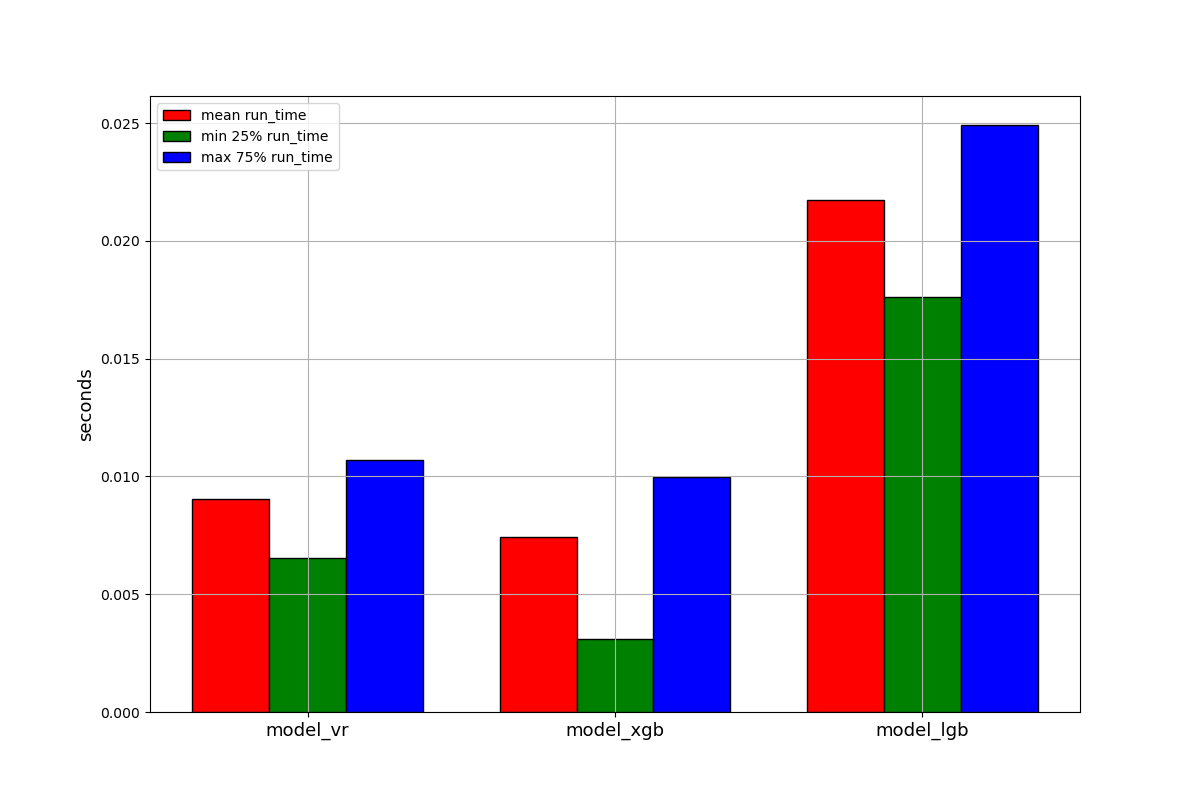

In [209]:

import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
IT = run_df.loc['mean'].values
ECE = run_df.loc['25%'].values
CSE = run_df.loc['75%'].values
 
# Set position of bar on X axis
br1 = np.arange(len(IT))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, IT, color ='r', width = barWidth,
        edgecolor ='k', label ='mean run_time')
plt.bar(br2, ECE, color ='g', width = barWidth,
        edgecolor ='k', label ='min 25% run_time')
plt.bar(br3, CSE, color ='b', width = barWidth,
        edgecolor ='k', label ='max 75% run_time')
 
# Adding Xticks

plt.ylabel('seconds', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(IT))],
        ['model_vr', 'model_xgb', 'model_lgb'], fontsize = 13)

plt.grid()
plt.legend()
plt.show()

***

In [ ]:
df_sim = gestures_test_2.iloc[:10000]
#df_sim = free_movements.iloc[:2000]
print(df_sim.shape)

(5330, 65)


In [ ]:
TIMEOUT = 0.33
DEBUG = True
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None

y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
    #'y_list':[],
}

while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed, y_previous)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)  
    y_dct['y_commands'].append(y_commands)
    
    y_previous = y_postprocessed
    
    # [/Data logging]
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    
    ts_old = ts_start
    i += 1 

SAMPLE SIZE: 65, OMG: 50, ACC: 6, ENCODERS: 6
BUTTON: 0, SYNC: 0, TS: 1041207
[25. 30. 40. 30. 30.  0.]


In [ ]:
#y_dct['y_commands'] = y_dct['y_commands'][1:]

for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (5330, 50)
enc_sample.shape = (5330, 6)
sample_preprocessed.shape = (5330, 50)
y_predicted.shape = (5330, 6)
y_postprocessed.shape = (5330, 6)
y_commands.shape = (5330, 6)


In [ ]:
MSE(y_dct['enc_sample'], y_dct['y_commands'])

NameError: name 'MSE' is not defined

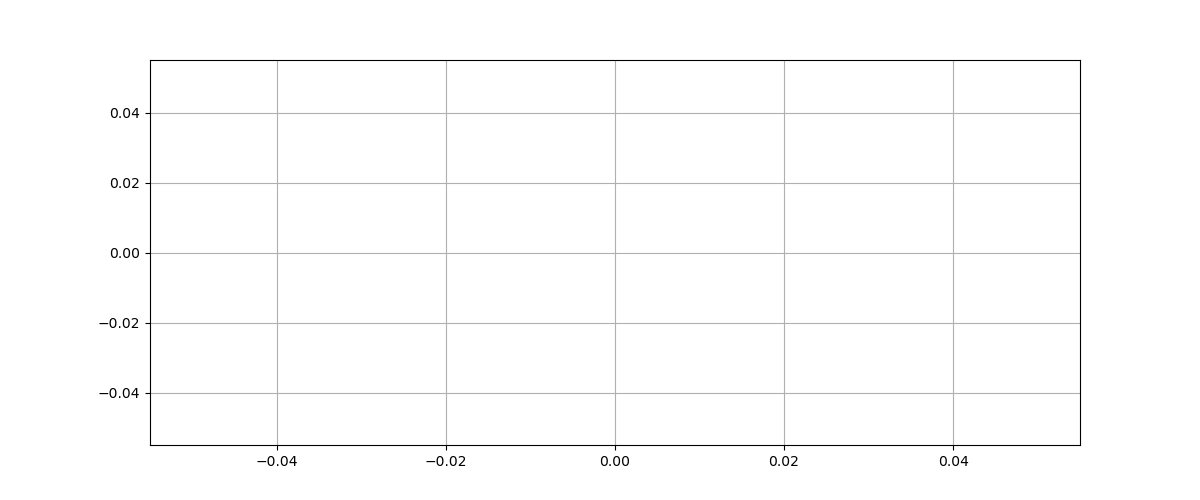

In [ ]:
plt.clf()
plt.cla()
fig = plt.figure(figsize=(12, 5))

plt.plot(y_dct['enc_sample'][:,4][5800:7000], color='blue')
plt.plot(y_dct['y_postprocessed'][:,4][5800:7000], color='red', alpha=0.7)
plt.plot(y_dct['y_commands'][:,4][5800:7000], color='orange', alpha=0.7)
plt.grid()

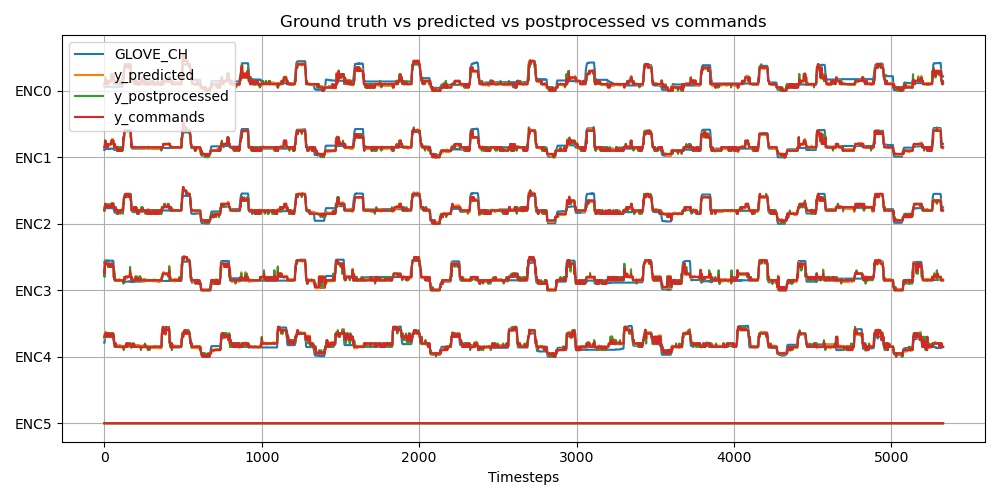

In [ ]:
plt.clf()
fig = plt.figure(figsize=(10, 5))

lines = []
labels = []

plots = plt.plot(df_sim[GLOVE_CH].values - np.arange(len(GLOVE_CH)) * 200, c='C0')
lines += [plots[0]]
labels += ['GLOVE_CH']

plots = plt.plot(y_dct['y_predicted'] - np.arange(len(GLOVE_CH)) * 200, c='C1')
lines += [plots[0]]
labels += ['y_predicted']

plots = plt.plot(y_dct['y_postprocessed'] - np.arange(len(GLOVE_CH)) * 200, c='C2')
lines += [plots[0]]
labels += ['y_postprocessed']

plots = plt.plot(y_dct['y_commands'] - np.arange(len(GLOVE_CH)) * 200, c='C3')
lines += [plots[0]]
labels += ['y_commands']

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(-np.arange(len(GLOVE_CH)) * 200, GLOVE_CH)
plt.legend(lines, labels)
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

## 5. Итоги спринта <a class="anchor" id=5></a>

[к содержанию](#0)

Я **очень** надеюсь, что правильно определил задачу первого спринта, как "общее знакомство с данными", потому, что на тестовых данных, модельки худо - бедно, но что-то показать могут, а вот со свободными жестами беда.. 

Но всё же:

* Стек из линейки и дерева вполне способен решить поставленную задачу.

* А градиентный бустинг буд-то бы созда для её решения.

* Но решения можно достигнуть при условии доработки **пред и постпроцессинга**, возможные пути:

* * Сглаживание показаний датчиков (где-то тут можно попробовать приложить авторегрессию)

* * Отсекание неинформативных датчиков (как определить какие датчики и **когда** являются "неинформативными" - отдельный вопрос)

* * Нужно больше узнать хардовую часть датчиков и процесса сьъёма показаний (хочется большей универсальности показаний, чтобы не было сильной разницы от "монтажа" и от "пилота", на данном этапе интуитивно хочется брать не сами показания а изменения в абсолютных значениях)

* * На постпроцессинге нужно срезать пики и убирать биения (сюда тоже можно приложить авторегрессию)


